In [13]:
import matplotlib.pyplot as plt
import pandas as pd

import keras
import keras.layers as layers

In [14]:
# read training data
# report_id - ID to identify report
# report_params - number of parameters to execute report (when more params specified - report will be generated faster)
# day_part - when report is executed (morning, midday or afternoon) - there is less load in the morning and in the afternoon reports are generated slower
# exec_time - time spent to produce report

column_names = ['report_id','report_params','day_part','exec_time']
raw_dataset = pd.read_csv('report_exec_times.csv')
dataset = raw_dataset.copy()

In [15]:
# report_id and day_part are categorical features. This means we need to encode these two attributes

report_id = dataset.pop('report_id')
day_part = dataset.pop('day_part')

In [16]:
# Encoding categorical attributes (creating as many columns as there are unique values and assigning 1 for the column from current row value)

dataset['report_1'] = (report_id == 1)*1.0
dataset['report_2'] = (report_id == 2)*1.0
dataset['report_3'] = (report_id == 3)*1.0
dataset['report_4'] = (report_id == 4)*1.0
dataset['report_5'] = (report_id == 5)*1.0

dataset['day_morning'] = (day_part == 1)*1.0
dataset['day_midday'] = (day_part == 2)*1.0
dataset['day_afternoon'] = (day_part == 3)*1.0

dataset.tail()

,report_params,exec_time,report_1,report_2,report_3,report_4,report_5,day_morning,day_midday,day_afternoon
1495,6,287,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1496,6,221,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1497,8,154,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1498,4,291,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1499,6,164,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [17]:
# Splitting training dataset into train (80%) and test data

train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_dataset.shape

(1200, 10)

In [18]:
test_dataset.shape

(300, 10)

In [19]:
# Describe train dataset, without target feature - exec_time. Mean and std will be used to normalize training data

train_stats = train_dataset.describe()
train_stats.pop("exec_time")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
report_params,1200.0,4.914167,3.159924,0.0,2.0,5.0,8.0,10.0
report_1,1200.0,0.191667,0.393776,0.0,0.0,0.0,0.0,1.0
report_2,1200.0,0.210000,0.407478,0.0,0.0,0.0,0.0,1.0
report_3,1200.0,0.192500,0.394428,0.0,0.0,0.0,0.0,1.0
report_4,1200.0,0.201667,0.401412,0.0,0.0,0.0,0.0,1.0
report_5,1200.0,0.204167,0.403259,0.0,0.0,0.0,0.0,1.0
day_morning,1200.0,0.360000,0.480200,0.0,0.0,0.0,1.0,1.0
day_midday,1200.0,0.320833,0.466991,0.0,0.0,0.0,1.0,1.0
day_afternoon,1200.0,0.319167,0.466348,0.0,0.0,0.0,1.0,1.0


In [20]:
# Remove exec_time feature from training data and keep it as a target for both training and testing

train_labels = train_dataset.pop('exec_time')
test_labels = test_dataset.pop('exec_time')

In [21]:
# Neural network learns better, when data is normalized (features look similar to each other)

def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [63]:
# Construct neural network with Keras API on top of TensorFlow. Using two layers with 50 units, non linear sigmoid activation, SGD optimizer and 
# mean squared error loss to check training quality

def build_model():
  model = keras.Sequential([
    layers.Dense(50, activation='sigmoid', input_shape=[len(train_dataset.keys())]),
    layers.Dense(50, activation='sigmoid'),
    layers.Dense(1)
  ])

  optimizer = keras.optimizers.SGD(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [64]:
model = build_model()

In [65]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 50)                500       
_________________________________________________________________
dense_23 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 51        
Total params: 3,101
Trainable params: 3,101
Non-trainable params: 0
_________________________________________________________________


In [66]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

# Using 20% of data for training validation
history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, batch_size=40, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [67]:
# Training quality results

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
995,16.945278,3.334376,16.945278,16.796739,3.361157,16.796739,995
996,16.118718,3.273908,16.118718,15.957192,3.266858,15.957192,996
997,16.352413,3.286015,16.352413,16.189042,3.303869,16.189042,997
998,16.820139,3.315669,16.820139,16.221551,3.298431,16.221551,998
999,16.231372,3.257963,16.231372,16.185107,3.297988,16.185107,999


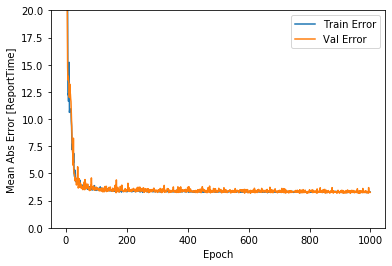

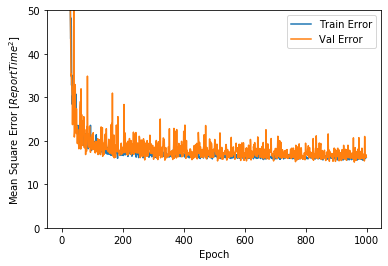

In [68]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [ReportTime]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$ReportTime^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,50])
  plt.legend()
  plt.show()


plot_history(history)


.......................................................................................

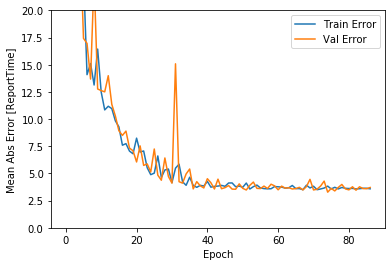

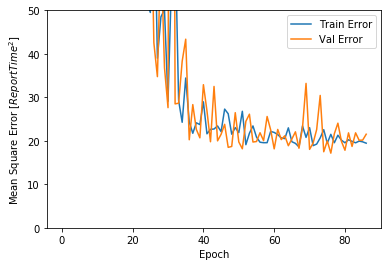

In [69]:
# Using early stopping functionality, if no improvement in 10 epochs

model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, batch_size=40, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [70]:
# Possible error of 3-4 seconds, this is acceptable

loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} Report Execution Time".format(mae))

Testing set Mean Abs Error:  3.65 Report Execution Time


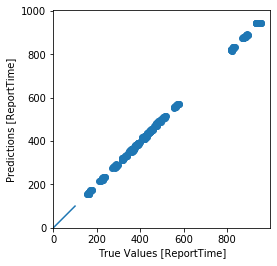

In [71]:
# Model predicts very well

test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [ReportTime]')
plt.ylabel('Predictions [ReportTime]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

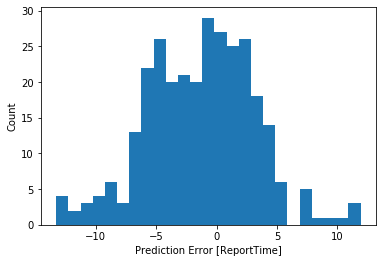

In [72]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [ReportTime]")
_ = plt.ylabel("Count")

In [73]:
# Save train model for later use

model.save("report_exec_times_model.h5")

In [103]:
# Construct test data row with "unseen" feature values - report_params = 15 

headers = ['report_id', 'report_params', 'day_part']
dataset_input = pd.DataFrame([[1, 15, 3]],
                                columns=headers, 
                                dtype=float,
                                index=['input'])

print(dataset_input)

       report_id  report_params  day_part
input        1.0           15.0       3.0


In [104]:
# Encode categorical features for test data row

report_id = dataset_input.pop('report_id')
day_part = dataset_input.pop('day_part')

dataset_input['report_1'] = (report_id == 1)*1.0
dataset_input['report_2'] = (report_id == 2)*1.0
dataset_input['report_3'] = (report_id == 3)*1.0
dataset_input['report_4'] = (report_id == 4)*1.0
dataset_input['report_5'] = (report_id == 5)*1.0

dataset_input['day_morning'] = (day_part == 1)*1.0
dataset_input['day_midday'] = (day_part == 2)*1.0
dataset_input['day_afternoon'] = (day_part == 3)*1.0

dataset_input.tail()

,report_params,report_1,report_2,report_3,report_4,report_5,day_morning,day_midday,day_afternoon
input,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [105]:
# Normalize test data row

normed_dataset_input = norm(dataset_input)

print(normed_dataset_input)

       report_params  report_1  report_2  report_3  report_4  report_5  \
input       3.191796  2.052773 -0.515365 -0.488049 -0.502393 -0.506291   

       day_morning  day_midday  day_afternoon  
input    -0.749687   -0.687022       1.459925  


In [106]:
# Prediction result for report execution time. This is correct, model learns the rule correct - more report params, means execution time will be less

res = model.predict(normed_dataset_input)
print(res)

[[ 429.1053772]]


In [107]:
# Testing to load saved model

from keras.models import load_model

modelFromFile = load_model('report_exec_times_model.h5')
modelFromFile.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 50)                500       
_________________________________________________________________
dense_26 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 51        
Total params: 3,101
Trainable params: 3,101
Non-trainable params: 0
_________________________________________________________________


In [108]:
# Running predict with saved model

res = modelFromFile.predict(normed_dataset_input)
print(res)

[[ 429.1053772]]
